In [1]:
## Libraries
import numpy as np
import matplotlib.pyplot as plt


## Plot settings
plt.rc('xtick', direction='in', labelsize=14)
plt.rc('ytick', direction='in', labelsize=14)
plt.rc('axes', labelsize=20, titlesize=22)
plt.rc('legend', fontsize=14)
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Computer Modern Roman']
plt.rcParams['mathtext.fontset'] = 'cm'

In [3]:
## Read coordinates and indices

grid_coordinates = []
with open('../../Grids/Pe_grid.txt', 'r') as reader:
    line = reader.readline()

    while line != '':
        elements = line.split(',')
        point = (float(elements[0]),float(elements[1]))
        grid_coordinates.append(point)
        line = reader.readline()

jump_coordinates = []
with open('../../Grids/Pe_jump_coordinates.txt', 'r') as reader:
    line = reader.readline()

    while line != '':
        elements = line.split(' ')
        data_block = []
        for ele in elements:
            temp = ele.replace('(', '').replace(')', '')
            if temp != 'stop':
                x = temp.split(',')[0]
                y = temp.split(',')[1]
                point = (float(x),float(y))
                data_block.append(point)
            else:
                break
        line = reader.readline()
        jump_coordinates.append(data_block)

jump_indices = []
with open('../../Grids/Pe_jump_indices.txt', 'r') as reader:
    line = reader.readline()

    while line != '':
        elements = line.split(' ')
        data_block = []
        for ele in elements:
            if ele != 'stop':
                data_block.append(int(ele))
            else:
                break
        line = reader.readline()
        jump_indices.append(data_block)

bott_indices = []
with open('Pe_Bott_indices.txt', 'r') as reader:
    line = reader.readline()
    
    while line != '':
        ele = line.replace('(', '').replace(')', '')
        elements = ele.split(',')
        package = (float(elements[0]), int(elements[1]))
        line = reader.readline()
        bott_indices.append(package)

# For drawing vertices use grid_coordinates
# For drawing lines use jump_coordinates
# For indices use jump_indices

## We now want to scale down the plot so it will fit inside a unit square in the 1st quadrant

# Compare x and y components seperatly to for the maximal distances along each axis
xs = [x for x,y in grid_coordinates]
ys = [y for x,y in grid_coordinates]

xs_length = abs(max(xs)) + abs(min(xs))
ys_length = abs(max(ys)) + abs(min(ys))

# We can now scale all xs and ys to fit inside a unit square
xs_scaled = [i/xs_length for i in xs]
ys_scaled = [i/ys_length for i in ys]
grid_scaled = [(x,y) for x, y in zip(xs_scaled, ys_scaled)]

# Same thing for all jump coodinates
jump_scaled = []
for i in jump_coordinates:
    xs_temp = [j[0]/xs_length for j in i]
    ys_temp = [j[1]/ys_length for j in i]
    jump_temp = [(x,y) for x, y in zip(xs_temp, ys_temp)]
    jump_scaled.append(jump_temp)


# The new vertices are stored in grid_scaled
# The new jumps are stored in jump_scaled

## IMPORTANT WE WILL USE THE GRID SCALED FOR ROTATIONS THIS MAKES THE WORK EASIER ##

## DEFINITION OF USEFUL FUNCTIONS

# We now change the Hamiltonian to be rotationally symmetric a thus we change the Peierls phase
# Calculation in notes
# Everything else is identical to the other rotation script
def Hamil_solve(z, w, B):
    # Define now a skeleton of the Hamiltonian 
    dim_H = len(z)
    H = np.zeros((dim_H, dim_H), dtype= np.complex128)
    k_H = [x for x in range(0, dim_H)]
    # Calculate Peierls phase factor according to the 1st artcle 
    
    # Start by finding the tile length
    tile_lens = [np.linalg.norm(np.array(z[0]) - np.array(x)) for x in w[0]]
    tile_lens_sum = np.sum(tile_lens)
    l  = tile_lens_sum/len(tile_lens)
    phi = B * l**2
    phi_0 = 2 * np.pi
    jump_products = []
    for i, j in zip(z, w):
        products = [(i[0]*k[1] - k[0]*i[1]) for k in j]
        jump_products.append(products)
    phase_factors = []
    for i, j in zip(z, jump_products):
        phases = [-(phi/(2 * l**2)) * k for k in j]
        phase_factors.append(phases)

    # Scaling via J, maybe energy factor
    J = 1
    # Fill out the Hamiltonian according to the psi vector, i.e. the basis chosen through generation of the tiling
    for x, y, z in zip(k_H, jump_indices, phase_factors):
        for k, t in zip(y, z):
            H[x, k] = -J * np.exp(1j * t)

    # Now we find the eigenvalues and eigenvectors
    # Note that eigh returns normalized eigenvectors!
    # Note the eigenvectors are arranged in a matrix so eig_vecs[:,i] chooses the i'th column which is the i'th eigenvector
    eig_vals, U = np.linalg.eigh(H)
    eig_vecs = np.array([U[:,i] for i in range(len(U))])
    return eig_vals, eig_vecs, H

# We want to know when phi/phi0 = 1, this happens when phi = 2pi
# phi in this case is phi = B*l*2 so B must be equal to
B_full = 812.549720608777

# Take field strength of B= 2pi so that phi/phi0= 0.5
evals, evecs, H = Hamil_solve(grid_scaled, jump_scaled, (0.25)*B_full)

# Read the phases in
evec_phases = []
with open('../../Separate_files/Pe_args.txt', 'r') as reader:
    line = reader.readline()

    while line != '':
        ele = line.strip('\n')
        val = float(ele)
        evec_phases.append(val)
        line = reader.readline()

phases_ind = [(ele, count) for count, ele in enumerate(evec_phases)]

# For easy transition between basis
def evec_to_site(evec):
    # Start by calculating the inner produts of vdot(ei, sk) for all k this will be the i'th column. s denotes site vectors
    # Site vectors have one entry equal to 1 while the rest are equal to 0. Thus the i,k'th inner product is just selecting the k'th value the i'th vectors complex conjugate
    # This means the coordinate transformation matrix ith column is just the ith eigenvector
    T = np.zeros((len(evals), len(evals)), dtype= np.complex128)
    for i in range(len(evals)):
        T[:, i] = evecs[i]
    # Now we can transform phi_evolve into the basis of lattice sites
    phi_lat = np.matmul(T,evec)
    # phi is normalised 
    phi_norm = phi_lat / (np.sqrt(np.vdot(phi_lat,phi_lat)))

    return phi_norm

dim = len(evecs)
# Similar story
def site_to_evec(state):
    # Localise a particle in site basis, and describe it as a linear combination in the basis of eigenvectors of the hamiltonian
    local_particle = np.zeros(dim, dtype= np.complex128)
    local_particle[state] = 1
    
 
    # We take the inner product of localised particle and all eigenstates of the hamilton
    # The coefficients will be used for creating phi as a linear combination of eigenstates
    cns = [np.vdot(x, local_particle) for x in evecs]
    
    # We can write phi in the basis of eigenstates for the hamiltonian
    phi = np.zeros(len(evals), dtype= np.complex128)
    for i, ele in enumerate(cns):
        phi[i] = ele

    # Now we can normalize and return 
    phi_norm = phi / (np.sqrt(np.vdot(phi,phi)))

    return phi_norm

def time_evolve_evec(group_of_states, time, evec, eval):

    hbar = 1
    t = time

    # Make the group of states in to vectors and multiply with time op
    phis = [np.exp(1j*(eval[i]/hbar)*t)*evec[i] for i in group_of_states]

    # Make a linear combination equally divided
    a = len(phis)
    psi = sum([(1/a)*x for x in phis])

    phi_norm = psi / (np.sqrt(np.vdot(psi,psi)))

    density_of_states = [(x.conj() * x).real for x in phi_norm]
    
    return phi_norm, density_of_states


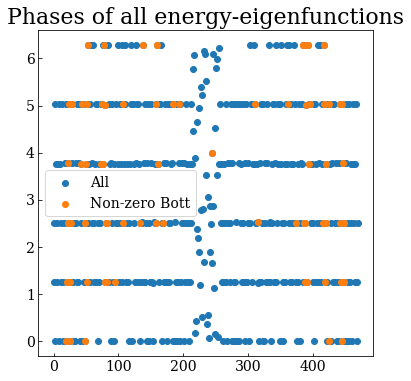

In [4]:
# Now we want to examine phases of all eigenvectors

fig, ax = plt.subplots(figsize= (6,6))

indices = np.arange(0,len(evecs))

# First we plot all phases
ax.scatter(x= indices, y= evec_phases, label= 'All')

# Now we highlight all with interesting Bott indices
# First select only bott indices
b_indices = [x[1] for x in bott_indices]
ys_ex = [evec_phases[i] for i in b_indices]
ax.scatter(x= b_indices, y= ys_ex, label= 'Non-zero Bott')

ax.legend()
ax.set_title('Phases of all energy-eigenfunctions')
plt.show()

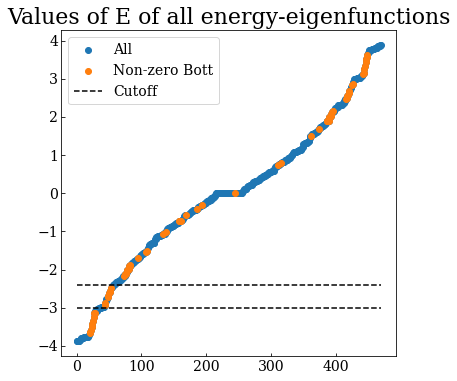

In [22]:
# Plot of E as a function of site number
fig, ax = plt.subplots(figsize= (6,6))

xs = np.arange(0,len(evecs))

# First we plot all phases
ax.scatter(x= xs, y= evals, label= 'All')

# Now we highlight all with interesting Bott indices
# First select only bott indices
b_indices = [x[1] for x in bott_indices]
ys_ex = [evals[i] for i in b_indices]
ax.scatter(x= b_indices, y= ys_ex, label= 'Non-zero Bott')

cutoff_low = -3
cutoff_high = -2.4
ax.hlines(y= cutoff_low, xmin= min(xs), xmax= max(xs), linestyles= '--', colors= 'k')
ax.hlines(y= cutoff_high, xmin= min(xs), xmax= max(xs), linestyles= '--', colors= 'k', label= 'Cutoff')


ax.legend()
ax.set_title('Values of E of all energy-eigenfunctions')
plt.show()

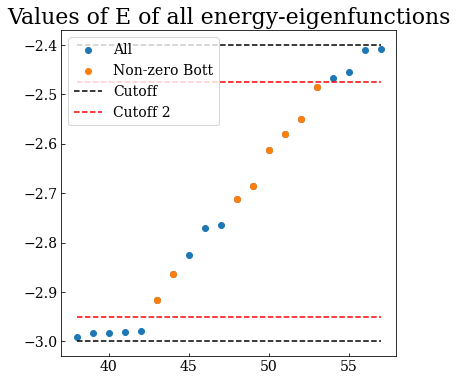

In [30]:
# Filter according to the above cutoff
filt_evals = [(ele, i) for i, ele in enumerate(evals) if cutoff_low <= ele and ele <= cutoff_high]

# Plot of E as a function of site number
fig, ax = plt.subplots(figsize= (6,6))

xs = [i for ele, i in filt_evals]
ys = [ele for ele, i in filt_evals]

# First we plot all phases
ax.scatter(x= xs, y= ys, label= 'All')

# Now we highlight all with interesting Bott indices
# First select only bott indices
b_indices = [x[1] for x in bott_indices]
eles_ex_temp = []
for ele, i in filt_evals:
    ele_temp = [(ele, i) for x in b_indices if i == x]
    eles_ex_temp.append(ele_temp)
eles_ex = [item for sublist in eles_ex_temp for item in sublist]

xs_ex = [i for ele, i in eles_ex]
ys_ex = [ele for ele, i in eles_ex]

ax.scatter(x= xs_ex, y= ys_ex, label= 'Non-zero Bott')

cutoff_low = -3
cutoff_high = -2.4
ax.hlines(y= cutoff_low, xmin= min(xs), xmax= max(xs), linestyles= '--', colors= 'k')
ax.hlines(y= cutoff_high, xmin= min(xs), xmax= max(xs), linestyles= '--', colors= 'k', label= 'Cutoff')

cutoff_low2 = -2.95
cutoff_high2 = -2.475
ax.hlines(y= cutoff_low2, xmin= min(xs), xmax= max(xs), linestyles= '--', colors= 'r')
ax.hlines(y= cutoff_high2, xmin= min(xs), xmax= max(xs), linestyles= '--', colors= 'r', label= 'Cutoff 2')


ax.legend()
ax.set_title('Values of E of all energy-eigenfunctions')
plt.show()

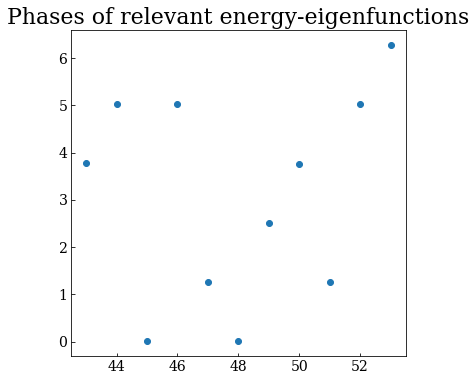

In [31]:
# Filter again and check for rotation eigenvalues
filt_evals2 = [(ele, i) for i, ele in enumerate(evals) if cutoff_low2 <= ele and ele <= cutoff_high2]
filt_phases2 = [evec_phases[i] for ele, i in filt_evals2]

# Plot of E as a function of site number
fig, ax = plt.subplots(figsize= (6,6))

xs = [i for ele, i in filt_evals2]

# First we plot all phases
ax.scatter(x= xs, y= filt_phases2)

ax.set_title('Phases of relevant energy-eigenfunctions')
plt.show()

In [32]:
# Now we look to plot DOS for the different eigenvectors

relevant_in = [i for ele, i in filt_evals2]

relevant_evecs = [evecs[i] for i in relevant_in]

for index, phi in zip(relevant_in, relevant_evecs):
    densities = [(x.conj() * x).real for x in phi]

    # Define figure
    fig, ax = plt.subplots(figsize=(6,6))

    # Plot all possible paths between vertices
    """for i,j in zip(grid_scaled, jump_scaled):
        xs = [w[0] for w in j]
        ys = [w[1] for w in j]
        for l,k in zip(xs,ys):
            ax.plot([i[0], l], [i[1], k], color= 'k', zorder= 1, linewidth= 0.5)"""

    marker_size = 33

    xs = [w[0] for w in grid_scaled]
    ys = [w[1] for w in grid_scaled]

    # Set colour gradient
    plt.set_cmap('binary')

    # Plot, noting c sets the density
    cax = ax.scatter(x= xs, y= ys, s= marker_size, c= densities, zorder= 3, facecolor= 'r')
    # Attach colorbar
    fig.colorbar(cax)

    # Finalize
    plt.axis('equal')
    plt.title(f'Eigenvector density plot, index= {index}')

    plt.savefig(f'Pe_BLT_search_for_transport/index_{index}')
    plt.close()